In [ ]:
!cp -r /kaggle/input/khrm-for-openpolymer /kaggle/working/.

In [ ]:
!cp -r /kaggle/input/khrm-for-openpolymer /kaggle/working/.
!cd /kaggle/working/khrm-for-openpolymer
!pip install --no-cache-dir torch-geometric -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install --no-cache-dir torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install --no-cache-dir torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
#!pip install /kaggle/input/torch-geometric/torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl
!pip install  "pyscf>=2.10.0" "pyscf-semiempirical>=0.1.1" "pysmiles>=2.0.0" "rdkit>=2025.3.5"

In [71]:
import os
import sys
import math
import json
from typing import List, Tuple, Dict
from datetime import datetime

import numpy as np
import pandas as pd

import torch

# Data props
PROPERTIES = ["Tg", "FFV", "Tc", "Density", "Rg"]
INPUTS = ["SMILES"]
AUX_INFO = ["monomer_count", "original_atoms", "final_atoms", "SMILES"]

# y output
TARGET_DIM = len(PROPERTIES)

# Params
EPOCHS = 2
BATCH_SIZE = 16
LR = 1e-3
WEIGHT_DECAY = 1e-4
CHECKPOINT_EVERY_N_STEPS = 100
K_HEADS = 1

# data params
VAL_RATIO = 0.1
MIN_LENGTH = 100
MAX_OUTPUT = 10


# Random seeding
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [72]:
import os

PROJECT_ROOT = "/home/thomaspugh/projects/chem-properties"
DATA_CSV = os.path.join(PROJECT_ROOT, "data", "train.csv")
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "checkpoints", "hrm")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [73]:
# Load data

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

LOAD_COLS = (INPUTS + PROPERTIES)

raw_df = pd.DataFrame(columns=LOAD_COLS)
import os
for dirname, _, filenames in os.walk(PROJECT_ROOT+'/data/'):
    for filename in filenames:
        if ('dataset' in filename and '.csv' in filename) or 'train.csv' in filename:
            df_temp = pd.read_csv(os.path.join(dirname, filename))
            df_temp.reindex(columns=LOAD_COLS)
            raw_df = pd.concat([raw_df, df_temp], ignore_index=True)

print(len(raw_df))


16963


In [74]:
 # !pip install -e /kaggle/input/khrm-for-openpolymer --no-deps --no-build-isolation

In [75]:
!pip install pysmiles
!pip install rdkit

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    For more information visit http://rptl.io/venv

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    ins

In [76]:
import sys
#sys.path.append("/kaggle/input/khrm-for-openpolymer/src")
import data_gen_helpers
from data_gen_helpers import iterative_extend_smiles, count_non_hydrogen_atoms

import logging
from datetime import datetime

from multiprocessing import Pool, cpu_count
N_PROCESSES = max(cpu_count()-1, 1)

def process_row(args):
    idx, row = args
    original_smiles = row["SMILES"]
    original_atoms = count_non_hydrogen_atoms(original_smiles)

    try:
        extensions = list(iterative_extend_smiles(
            original_smiles,
            min_length=MIN_LENGTH,
            max_output=MAX_OUTPUT
        ))

        results = []
        if extensions:
            for extended_smiles, monomer_count in extensions:
                final_atoms = count_non_hydrogen_atoms(extended_smiles)
                new_row = row.copy()
                new_row["SMILES"] = extended_smiles
                new_row["monomer_count"] = monomer_count
                new_row["original_smiles"] = original_smiles
                new_row["original_atoms"] = original_atoms
                new_row["final_atoms"] = final_atoms
                results.append(("success", new_row))
        else:
            return [("fail", (idx, original_smiles, "No extensions generated"))]

        # FIX: don't double-wrap
        return results

    except Exception as e:
        return [("fail", (idx, original_smiles, str(e)))]
        
# ---- Parallel Execution ----
def parallel_extend(raw_df):
    extended_data = []
    failed_extensions = []

    with Pool(N_PROCESSES) as pool:
        for results in pool.imap_unordered(process_row, raw_df.iterrows(), chunksize=10):
            for status, payload in results:
                if status == "success":
                    extended_data.append(payload)
                else:
                    failed_extensions.append(payload)

    # Build DataFrame
    mixed_fields=(["SMILES", "monomer_count", "original_smiles", "original_atoms", "final_atoms"]+PROPERTIES)
    extended_df = pd.DataFrame(extended_data, columns = mixed_fields)
    print(f"\nSuccessfully extended: {len(extended_df)} molecules")
    print(f"Failed extensions: {len(failed_extensions)}")

    if failed_extensions:
        print("\n\nFailed molecules:\n\n")
        for idx, smiles, error in failed_extensions[:5]:
            print(f"  {idx}: {smiles} - {error}")

    if len(extended_df) == 0:
        raise RuntimeError("No molecules could be extended. Check your data and extension logic.")

    return extended_df, failed_extensions

# ---- Run ----
extended_df, failed_extensions = parallel_extend(raw_df[:2])
if len(failed_extensions) > 0:
    print("\n\nFailed molecules:\n\n")
    for idx, smiles, error in failed_extensions:  # Show first 5 errors
        print(f"  {idx}: {smiles} - {error}")

print(extended_df.columns)

# Use extended data for training
if len(extended_df) == 0:
    raise RuntimeError("No molecules could be extended. Check your data and extension logic.")


The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information
The SMILES writer does not write stereochemical information



Successfully extended: 11 molecules
Failed extensions: 0
Index(['SMILES', 'monomer_count', 'original_smiles', 'original_atoms',
       'final_atoms', 'Tg', 'FFV', 'Tc', 'Density', 'Rg'],
      dtype='object')


In [77]:
!pip install geometric

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    For more information visit http://rptl.io/venv

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.


In [78]:
from dataset_helpers import smiles_iter_to_graph_dataset

import numpy as np
from torch_geometric.loader import DataLoader

# Split into Train/Val
num_rows = len(extended_df)
perm = np.random.RandomState(SEED).permutation(num_rows)
train_count = int((1.0 - VAL_RATIO) * num_rows)
train_idx, val_idx = perm[:train_count], perm[train_count:]
train_df = extended_df.iloc[train_idx].reset_index(drop=True)
val_df = extended_df.iloc[val_idx].reset_index(drop=True)

# Create graph datasets
train_dataset = smiles_iter_to_graph_dataset(train_df["SMILES"], torch.tensor(train_df[PROPERTIES].to_numpy(), dtype=torch.float32, device=device), aux_info=train_df[AUX_INFO])
val_dataset = smiles_iter_to_graph_dataset(val_df["SMILES"], torch.tensor(val_df[PROPERTIES].to_numpy(), dtype=torch.float32, device=device), aux_info=val_df[AUX_INFO])

print(f"example aux_info: {train_dataset[0].aux_info}")
print(f"Train graphs: {len(train_dataset)} | Val graphs: {len(val_dataset)}")

# DataListLoader (batched lists of Data objects)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Derive input dimension from first training graph
if len(train_dataset) == 0:
    raise RuntimeError("Training dataset is empty after preprocessing.")
INPUT_DIM = train_dataset[0].x.shape[1]
print(f"Input dim: {INPUT_DIM}, Target dim: {TARGET_DIM}")

EDGE_DIM = train_dataset[0].edge_attr.shape[1]
print(f"Edge dim: {EDGE_DIM}")

# Show some examples of the extensions
print(f"\nExamples of SMILES extensions:")
for i in range(min(3, len(train_df))):
    row = train_df.iloc[i]
    print(f"Original ({row.get('original_atoms', 'N/A')} atoms): {row.get('original_smiles', 'N/A')}")
    print(f"Extended ({row.get('final_atoms', 'N/A')} atoms): {row['SMILES']}")
    print()

TOTAL_BATCH_COUNT = len(train_loader)

example aux_info: [2 17 104
 'CCCCCCOC(=O)c1ccccc1C(C)CC(CCC(CC(CC(CC(C)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC']
Train graphs: 9 | Val graphs: 2
Input dim: 6, Target dim: 5
Edge dim: 4

Examples of SMILES extensions:
Original (17 atoms): *CC(*)c1ccccc1C(=O)OCCCCCC
Extended (104 atoms): CCCCCCOC(=O)c1ccccc1C(C)CC(CCC(CC(CC(CC(C)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC)c1ccccc1C(=O)OCCCCCC

Original (17 atoms): *CC(*)c1ccccc1C(=O)OCCCCCC
Extended (36 atoms): CCCCCCOC(=O)c1ccccc1C(C)CCC(C)c1ccccc1C(=O)OCCCCCC

Original (45 atoms): *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5ccc(N*)cc5)cc4)CCC(CCCCC)CC3)cc2)cc1
Extended (92 atoms): CCCCCC1CCC(c2ccc(C(CCC)c3ccc(NC)cc3)cc2)(c2ccc(C(CCC)c3ccc(NNc4ccc(C(CCC)c5ccc(C6(c7ccc(C(CCC)c8ccc(NC)cc8)cc7)CCC(CCCCC)CC6)cc5)cc4)cc3)cc2)CC1



In [9]:
import kmeans_hrm_model
# Use KMeansHRMModule from kmeans_hrm_model.py
from kmeans_hrm_model import (
    KMeansHRMModule, KMeansHRMConfig, KMeansHRMInnerModuleConfig, KMeansHRMInitialCarry,
    KMeansConfig, KMeansHeadConfig, OutputHeadConfig,
    SpectralWeighting, SpectralWeightingConfig,
    DiscreteMeanCenter, DiscreteMeanCenterConfig,
    RadiusAttentionWeights, RadiusMaskConfig
)
from torch.optim import Adam
from torch_geometric.nn import GATConv

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def create_kmeans_hrm_config(input_dim: int, edge_dim: int, hidden_dim: int = 4, latent_dim: int = 4, output_dim: int = TARGET_DIM, k: int = 2) -> KMeansHRMConfig:
    
    # Spectral Weighting Configuration
    spectral_config = SpectralWeightingConfig(
        node_channels=latent_dim,
        K=3,  # Chebyshev polynomial order
        num_layers=3,
        normalization='sym',
        bias=True,
        dropout=0.2,
        norm='batch',
        norm_kwargs={'in_channels': latent_dim}
    )
    
    # Center Module Configuration
    center_config = DiscreteMeanCenterConfig(
        distance_metric='euclidean'
    )
    
    # Radius Mask Configuration (simplified weighting module)
    radius_weighting = GATConv(latent_dim, latent_dim)
    radius_config = RadiusMaskConfig(
        max_num_neighbors=50,
        radius=20,
        weighting_module=radius_weighting,
        threshold=0.1,
        node_dim=latent_dim
    )
    
    # KMeans Head Configuration
    kmeans_head_config = KMeansHeadConfig(
        node_count=k,
        node_dim=latent_dim,
        max_nodes=100,  
        num_layers=5,
        dropout=0.2,
        weighting_module=SpectralWeighting(spectral_config),
        center_module=DiscreteMeanCenter(center_config),
        mask_module=RadiusAttentionWeights(radius_config),
        act='relu',
        act_kwargs={}
    )
    
    # KMeans Configuration
    kmeans_config = KMeansConfig(
        k=k,
        max_iter=15,
        thresh=1e-6,
        max_overlap=2,
        head_module=kmeans_head_config,
        excluded_is_cluster=True
    )
    
    # Output Head Configuration
    output_head_config = OutputHeadConfig(
        node_dim=latent_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        pooling_type='mean',
        norm='batch',
        norm_kwargs={'in_channels': hidden_dim},
        act='relu',
        act_kwargs={}
    )
    
    # Policy Module Configuration
    policy_config = OutputHeadConfig(
        node_dim=latent_dim,
        hidden_dim=hidden_dim//2,
        output_dim=2,  # halt=0, continue=1
        pooling_type='mean',
        norm='batch',
        norm_kwargs={'in_channels': hidden_dim//2},
        act='relu',
        act_kwargs={}
    )
    
    # Inner Module Configuration
    inner_config = KMeansHRMInnerModuleConfig(
        add_self_loops=True,
        add_negative_edges=True,
        dropout=0.2,
        hidden_dim=hidden_dim,        # inner-side hidden size, reused
        node_dim=latent_dim,          # must equal vgae_latent_dim
        attention_dim=4,           # bigger in final
        edge_dim=edge_dim,
        layers=3,
        kmeans_config=kmeans_config,
        output_head_config=output_head_config,
        policy_module_config=policy_config,
        K_cycles=8,
        L_cycles=30,
        batch_size=BATCH_SIZE,
        halt_max_steps=10,
        halt_exploration_prob=0.1,
    )
    
    config = KMeansHRMConfig(
        inner_module=inner_config,
        explore_steps_prob=0.1,
        halt_max_steps=10,
        pre_encoder_conv_layers=2,
        vgae_encoder_type="cheb",
        input_dim=input_dim,
        edge_attr_dim=edge_dim,
        vgae_latent_dim=latent_dim,           # must equal inner.node_dim
        vgae_encoder_layers=2,
        vgae_encoder_dropout=0.1,
        vgae_decoder_type=None,
        vgae_kl_weight=1.0,
    )
    
    return config

# Modell initialisieren
#hrm_config = create_kmeans_hrm_config(INPUT_DIM, EDGE_DIM, latent_dim=256, hidden_dim=128, output_dim=TARGET_DIM, k=16)
hrm_config = create_kmeans_hrm_config(INPUT_DIM, EDGE_DIM, latent_dim=4, hidden_dim=4, output_dim=TARGET_DIM, k=2)
model = KMeansHRMModule(hrm_config, training=True).to(device)
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Print number of parameters
num_params = count_parameters(model)
print(f"KMeansHRMModule created with {num_params:,} trainable parameters")
print(f"Model size: {num_params * 4 / 1024 / 1024:.2f} MB (float32)")
print(model)


KMeansHRMModule created with 3,106 trainable parameters
Model size: 0.01 MB (float32)
KMeansHRMModule(
  (inner_module): KMeansHRMInnerModule(
    (kmeans_module): KMeans(
      (heads): ModuleList(
        (0-1): 2 x KMeansHead(
          (weighting_module): SpectralWeighting(
            (cheb_convs): ModuleList(
              (0-2): 3 x ChebConv(4, 4, K=3, normalization=sym)
            )
            (norms): ModuleList(
              (0-2): 3 x BatchNorm(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (center_module): DiscreteMeanCenter(
            (distance_module): PairwiseDistance()
          )
          (mask_module): RadiusAttentionWeights(
            (weighting_module): GATConv(4, 4, heads=1)
            (_mask_linear): Linear(in_features=4, out_features=1, bias=True)
          )
          (act): ReLU()
        )
      )
    )
    (vgae_encoder): VGAEEncoder(
      (norms): ModuleList(
        (0-2): 3 x LayerNorm(4, af

In [10]:
import training_loops
from training_loops import composite_loss, compute_mae_in_bounds, init_property_bounds

init_property_bounds(PROPERTIES, extended_df)

from typing import TypedDict, Dict, Any
from dataclasses import dataclass

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
from torch.optim import Adam

from torch_geometric.data import Data, Batch

def save_checkpoint(state: Dict, step: int, is_best: bool = False):
    path = os.path.join(CHECKPOINT_DIR, f"step_{step}.pt")
    torch.save(state, path)
    if is_best:
        best_path = os.path.join(CHECKPOINT_DIR, "best.pt")
        torch.save(state, best_path)


class PretrainConfig(TypedDict):
    # Data
    data_path: str

    # Hyperparams
    global_batch_size: int
    epochs: int
    total_iters: int

    lr: float
    lr_min_ratio: float
    lr_warmup_steps: int

    weight_decay: float
    beta1: float
    beta2: float


@dataclass
class TrainState:
    model: nn.Module
    optimizer: torch.optim.Optimizer
    carry: KMeansHRMInitialCarry | None

    step: int
    total_steps: int


def compute_warmup_weight(step: int, warmup_steps: int, min_ratio: float) -> float:
    if warmup_steps <= 0:
        return 1.0
    if step < warmup_steps:
        # Linear warmup from min_ratio -> 1.0
        return float(min_ratio + (1.0 - min_ratio) * (step / max(1, warmup_steps)))
    return 1.0


def pack_train_state_for_save(ts: TrainState) -> Dict[str, Any]:
    return {
        "step": int(ts.step),
        "total_steps": int(ts.total_steps),
        # Carry can be large; still useful for exact resume within the same batch sequence
        "carry": ts.carry,
    }


Loss and metrics initialized.


In [ ]:
def train_batch(epoch: int, train_state: TrainState, batch_data: Batch, config: PretrainConfig) -> Dict[str, float]:
    model = train_state.model
    optimizer = train_state.optimizer

    model.train()

    # Targets [B,5]
    y = torch.stack([g.y for g in batch_data.to_data_list()], dim=0).to(device)
    batch_data = batch_data.to(device)

    related_info = [torch.as_tensor(d[0]).unsqueeze(-1).to(device) for d in batch_data.aux_info]
    #related_info = batch_data.aux_info
    
    # Reuse existing carry if provided; otherwise initialize or realign to current num_graphs
    need_new_carry = (
        train_state.carry is None
        or (hasattr(batch_data, 'num_graphs') and train_state.carry.steps.numel() != batch_data.num_graphs)
    )
    if need_new_carry:
        train_state.carry = model.initial_carry(batch_data)

    # Forward
    train_state.carry, hrm_output = model(train_state.carry, batch_data)
    preds = hrm_output['y_pred'].to(device)
    policy = hrm_output['q_policy']
    target_policy = hrm_output.get('target_q_policy', None)

    targets = y
    properties = PROPERTIES

    if target_policy is not None and target_policy[0].size == policy[0].size:

        preds = torch.cat([preds, policy[0].unsqueeze(-1), policy[1].unsqueeze(-1)], dim=1)
        targets = torch.cat([y, target_policy[0].unsqueeze(-1), target_policy[1].unsqueeze(-1)], dim=1)

        properties += ['q_halt', 'q_cont']

    assert preds.size(0) == targets.size(0), f"batch mismatch: preds {preds.shape}, targets {targets.shape}"
    assert len(properties) == targets.size(1), f"mismatch {y.size} {properties}"

    loss = composite_loss(0, properties, preds, targets, related_info)

    train_state.step += 1
    warmup_w = compute_warmup_weight(train_state.step, config["lr_warmup_steps"], config["lr_min_ratio"])  # type: ignore[index]
    scaled_loss = loss * warmup_w * (1.0 / TOTAL_BATCH_COUNT)

    # Backward/update
    optimizer.zero_grad()
    scaled_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    optimizer.step()

    # Metrics (unscaled loss for logging)
    with torch.no_grad():
        metrics = compute_mae_in_bounds(0, properties, preds, targets, related_info)
        metrics.update({
            "loss": loss.item(),
            "warmup_weight": float(warmup_w),
        })


    # Periodic checkpoint
    global_step = train_state.step
    if global_step % CHECKPOINT_EVERY_N_STEPS == 0:
        save_checkpoint({
            "epoch": epoch,
            "global_step": global_step,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "model_class": model.__class__.__name__,
            "model_module": model.__class__.__module__,
            "train_state": pack_train_state_for_save(train_state),
        }, step=global_step)

    return metrics


@torch.no_grad()
def validate(epoch: int, model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    model.eval()
    running_loss = 0.0
    mae_accum = {f"mae_{p}": 0.0 for p in PROPERTIES + ['q_halt', 'q_cont']}
    count_samples = 0

    for batch_data in loader:
        # Targets [B,5]
        y = torch.stack([g.y for g in batch_data.to_data_list()], dim=0).to(device)
        batch_data = batch_data.to(device)

        related_info = [torch.as_tensor(d[0]).unsqueeze(-1).to(device) for d in batch_data.aux_info]
        #related_info = batch_data.aux_info
        
        carry = model.initial_carry(batch_data)
        
        carry, hrm_output = model(carry, batch_data)
        preds = hrm_output['y_pred'].to(device)
        policy = hrm_output['q_policy']
        target_policy = hrm_output.get('target_q_policy', None)
        
        targets = y
        properties = PROPERTIES

        if target_policy is not None and target_policy[0].size == policy[0].size:
    
            preds = torch.cat([preds, policy[0].unsqueeze(-1), policy[1].unsqueeze(-1)], dim=1)
            targets = torch.cat([y, target_policy[0].unsqueeze(-1), target_policy[1].unsqueeze(-1)], dim=1)
    
            properties += ['q_halt', 'q_cont']

        assert preds.size(0) == y.size(0), f"batch mismatch: preds {preds.shape}, targets {targets.shape}"
        assert len(properties) == targets.size(1), f"mismatch {y.size} {properties}"
    
        loss = composite_loss(0, properties, preds, targets, related_info)

        metrics = compute_mae_in_bounds(0, properties, preds, targets, related_info)
        for k, v in metrics.items():
            if not math.isnan(v):
                mae_accum[k] += v * preds.size(0)
        running_loss += loss.item() * preds.size(0)
        count_samples += preds.size(0)

    avg_loss = running_loss / max(1, count_samples)
    avg_mae = {k: (v / max(1, count_samples)) for k, v in mae_accum.items()}

    return {"loss": avg_loss, **avg_mae}


In [ ]:
from training_loops import train_until_total_iters

# Build a minimal config for warmup from existing hyperparams
CONFIG: PretrainConfig = {
    "data_path": "",
    "global_batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    # Step-based training support; used by helper loop
    "total_iters": int(EPOCHS * len(train_loader)),
    "lr": LR,
    "lr_min_ratio": 0.1,
    "lr_warmup_steps": max(1, len(train_loader) * 2),  # warm up first ~2 epochs of steps
    "weight_decay": WEIGHT_DECAY,
    "beta1": 0.9,
    "beta2": 0.999,
}

history = {"train": [], "val": []}
best_val_loss = float("inf")

# Initialize TrainState with total steps estimated from loader length and epochs
train_state = TrainState(
    model=model,
    optimizer=optimizer,
    carry=None,
    step=0,
    total_steps=EPOCHS * len(train_loader)
)

last_completed_epoch=0

history, best_val_loss = train_until_total_iters(
    total_iters=CONFIG["total_iters"],
    start_epoch=last_completed_epoch,
    train_state=train_state,
    train_loader=train_loader,
    val_loader=val_loader,
    config=CONFIG,
    train_batch_fn=train_batch,
    validate_fn=validate,
    save_checkpoint_fn=save_checkpoint,
    checkpoint_every_n=10,
    print_every_n=1
)

Initializing new carry for graphs=9
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
DataBatch(x=[787, 6], edge_index=[2, 1670], edge_attr=[1670, 4], y=[45], aux_info=[9], batch=[787], ptr=[10])
tensor([False, False, False, False, False, False, False, False, False])

*****
tensor([0.3448, 0.3179, 0.5661, 0.2919, 0.8027, 0.7913, 0.2919, 0.7569, 0.2919],
       grad_fn=<SelectBackward0>)
tensor([0.0878, 0.0380, 0.1340, 0.1128, 0.2203, 0.4481, 0.1128, 0.3648, 0.1128],
       grad_fn=<SelectBackward0>)
*****
step      1/2 | epoch   1 | batch    1 | loss=0.2549 | lr=0.001
*****
tensor([0.7267, 0.7362])
tensor([0.3384, 0.3448])
*****
[total_iters] Epoch 001 done | train_loss=0.2549 | val_loss=0.3121 | step=1/2
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
DataBatch(x=[787, 6], edge_index=[2, 1670], edge_attr=[1670, 4], y=[45], aux_info=[9], batch=[787], ptr=[10])
tensor([ True,  True,  True, False,  True,  True,  True,  True,  True])

*****
tensor([0.3315, 0.2919, 0.2919, 0.51

({'train': [{'epoch': 1,
    'loss': 0.2548984885215759,
    'mae_FFV': 0.09090761095285416,
    'mae_Tc': 0.12803027033805847},
   {'epoch': 2,
    'loss': 0.24077174067497253,
    'mae_FFV': 0.0798494815826416,
    'mae_Tc': 0.1316552460193634}],
  'val': [{'epoch': 1,
    'loss': 0.3121471405029297,
    'mae_Tg': 0.0,
    'mae_FFV': 0.0815361887216568,
    'mae_Tc': 0.21477890014648438,
    'mae_Density': 0.0,
    'mae_Rg': 0.0,
    'mae_q_halt': 0.0,
    'mae_q_cont': 0.0},
   {'epoch': 2,
    'loss': 0.3085313141345978,
    'mae_Tg': 0.0,
    'mae_FFV': 0.08326303958892822,
    'mae_Tc': 0.21271218359470367,
    'mae_Density': 0.0,
    'mae_Rg': 0.0,
    'mae_q_halt': 0.0,
    'mae_q_cont': 0.0}]},
 0.3085313141345978)

Saved metrics to /home/thomaspugh/projects/chem-properties/checkpoints/hrm/history.json


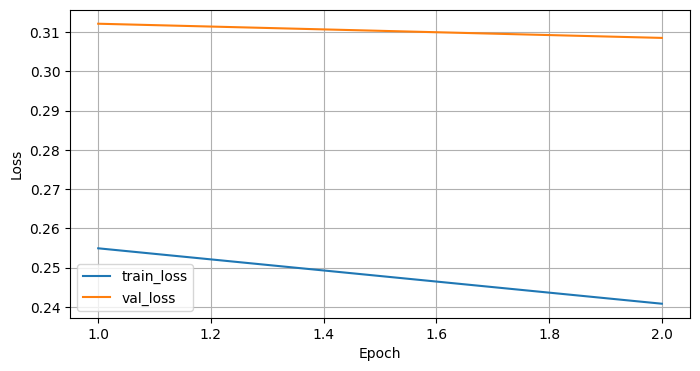

In [20]:
import matplotlib.pyplot as plt


metrics_path = os.path.join(CHECKPOINT_DIR, "history.json")
with open(metrics_path, "w") as f:
    json.dump(history, f, indent=2)
print(f"Saved metrics to {metrics_path}")

# Plot
def plot_curves(history):
    epochs = [e["epoch"] for e in history["train"]]
    train_losses = [e["loss"] for e in history["train"]]
    val_losses = [e["loss"] for e in history["val"]]

    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_losses, label="train_loss")
    plt.plot(epochs, val_losses, label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_curves(history)

In [103]:
from dataset_helpers import smiles_to_graph_data
import pandas as pd
from torch_geometric.loader import DataLoader

df = pd.read_csv('/home/thomaspugh/projects/chem-properties/data/test.csv')

COLS = (["SMILES", "id"] + PROPERTIES)

submission_df = pd.DataFrame(columns=COLS)
submission_df = pd.concat([submission_df, df], ignore_index=True)

inputs = df["SMILES"].tolist()
id = df["id"].tolist()

graph_data_list = [smiles_to_graph_data(smiles, None, [info]) for smiles, info in zip(inputs, id)]
print(graph_data_list)

test_loader = DataLoader(graph_data_list, batch_size=1, shuffle=False)

submission_df

[Data(x=[39, 6], edge_index=[2, 84], edge_attr=[84, 4], aux_info=[1]), Data(x=[39, 6], edge_index=[2, 86], edge_attr=[86, 4], aux_info=[1]), Data(x=[44, 6], edge_index=[2, 98], edge_attr=[98, 4], aux_info=[1])]


,SMILES,id,Tg,FFV,Tc,Density,Rg
0,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...,1109053969,NaN,NaN,NaN,NaN,NaN
1,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...,1422188626,NaN,NaN,NaN,NaN,NaN
2,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...,2032016830,NaN,NaN,NaN,NaN,NaN


In [104]:
model.eval()

max_iters = 10

with torch.no_grad():
    for datum in list(test_loader):
        preds = [0, 0, 0, 0, 0]
        while max_iters > 0:
            og_carry, hrm_output = model(carry, datum)

            preds = hrm_output['y_pred']
            q_policy = hrm_output['q_policy']

            print(preds)

            if q_policy[0] > q_policy[1]:
                break
            max_iters -= 1

        

        submission_df.loc[submission_df["id"] == datum.aux_info[0][0], PROPERTIES] = np.array(preds).flatten()
        
print('submission_df', submission_df)

*****
tensor([0.7296])
tensor([0.3238])
*****
tensor([[ 0.2772,  0.0369, -0.7698,  0.7983,  0.5048]])
*****
tensor([0.7292])
tensor([0.3205])
*****
tensor([[ 0.2750,  0.0405, -0.7768,  0.8033,  0.5064]])
*****
tensor([0.7031])
tensor([0.3120])
*****
tensor([[ 0.2760,  0.0191, -0.7439,  0.7826,  0.5096]])
submission_df                                               SMILES          id        Tg  \
0  *Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...  1109053969   0.27724   
1  *Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...  1422188626  0.274977   
2  *c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...  2032016830  0.276021   

        FFV        Tc   Density        Rg  
0    0.0369 -0.769776  0.798286  0.504831  
1  0.040493 -0.776847  0.803326  0.506407  
2  0.019146 -0.743947  0.782646  0.509562  


In [102]:
submission_df.to_csv('submission.csv', index=False)